## install visionlens

In [2]:
!rm -rf /kaggle/working/*
!git clone https://github.com/SKT27182/VisionLens.git
!mv  /kaggle/working/VisionLens/* .

Cloning into 'VisionLens'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243 (from 1)
Receiving objects: 100% (243/243), 34.98 MiB | 40.89 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [3]:
!pip3 install einops==0.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00


## imports

In [4]:
import torch
from torchvision.transforms import transforms
import numpy as np
from copy import deepcopy
from PIL import Image


from typing import Union

import einops
from matplotlib import pyplot as plt

from visionlens.models import InceptionV1
from visionlens.objectives import objective_wrapper
from visionlens.optimize import Visualizer
from visionlens import objectives
from visionlens.images import get_images
from visionlens.utils import device

In [5]:
model = InceptionV1(pretrained=True).eval()

Downloading: "https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth" to /root/.cache/torch/hub/checkpoints/inception5h.pth
100%|██████████| 27.0M/27.0M [00:00<00:00, 263MB/s]


## Style Transfer

In [6]:
def load_deepdream_img(file_path: str, img_size: tuple = (224, 224)) -> torch.Tensor:
    img = Image.open(file_path)
    img = img.resize(img_size)
    img = np.array(img)
    img = torch.tensor(img, dtype=torch.float32)
    img = img/255.0
    img = einops.rearrange(img, 'h w c -> 1 c h w')
    img = img.to(device)
    return img

In [7]:
from visionlens.images import STANDARD_TRANSFORMS, to_valid_rgb


layers = [
    # "mixed3a",
    # "mixed3b",
    "mixed4a",
    # "mixed4b",
    # "mixed4c",
    "mixed4d",
    "mixed4e",
    "mixed5a",
    "mixed5b",
]

orig_h = 512
orig_w = 720
image_name = "under_the_sea"
image = load_deepdream_img(f"images/{image_name}.jpg", img_size=(orig_h, orig_w))

def get_deepdream_image():

    param = image
    param.requires_grad = True

    return [param], to_valid_rgb(lambda : param, decorrelate=False)


octave_scale = 1.3
octaves = [-2, -1, 0, 1, 2]
octave_images = []
all_images = []


# @objective_wrapper
def mean_loss_obj(hooks):

    return -sum([hooks(layer).mean() for layer in layers]) / len(layers)

2024-11-30 13:32:56 - 30 - visionlens.img_utils.display_images_in_table:130 - INFO - Displaying 1 images in a table.


torch.Size([3, 720, 512])



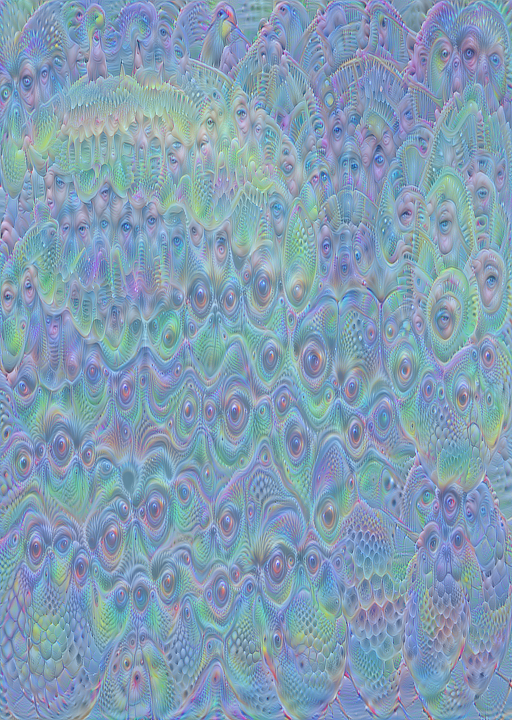

2024-11-30 13:32:56 - 30 - visionlens.optimize.visualize:182 - INFO - Epoch 200/201 - Loss: -103.69
2024-11-30 13:32:56 - 30 - visionlens.img_utils.display_images_in_table:130 - INFO - Displaying 1 images in a table.


torch.Size([3, 720, 512])



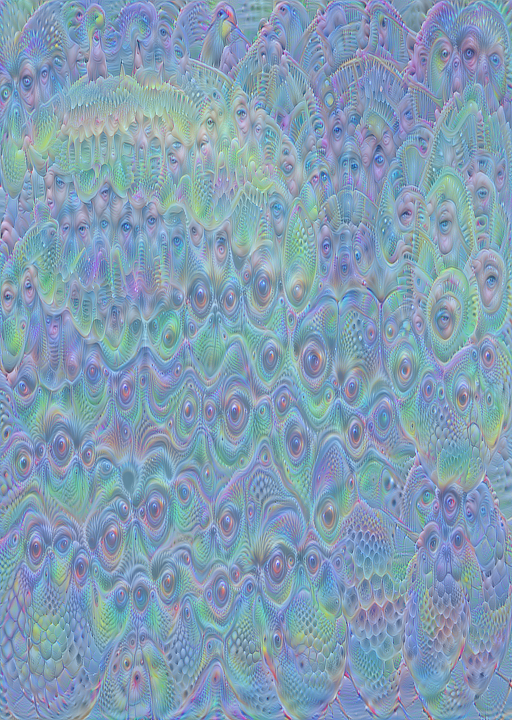

In [8]:
for octave in octaves:

    new_size_h = int(orig_h * octave_scale**octave)
    new_size_w = int(orig_w * octave_scale**octave)
    print(f"New Size: {(new_size_h, new_size_w)}")

    extra_t = STANDARD_TRANSFORMS.copy() + [
        lambda x: transforms.Resize((new_size_h, new_size_w))(x),
    ]

    viz = Visualizer(model, mean_loss_obj, transforms=extra_t)
    images = viz.visualize(
        get_deepdream_image,
        threshold=range(0, 201,  20),
        lr=0.007,
    )
    octave_images.append(images[-1])
    all_images.extend(images)

In [9]:
len(octave_images)

5

2024-11-30 13:40:17 - 30 - visionlens.img_utils.display_images_in_table:130 - INFO - Displaying 5 images in a table.


torch.Size([3, 720, 512])
torch.Size([3, 720, 512])
torch.Size([3, 720, 512])
torch.Size([3, 720, 512])
torch.Size([3, 720, 512])



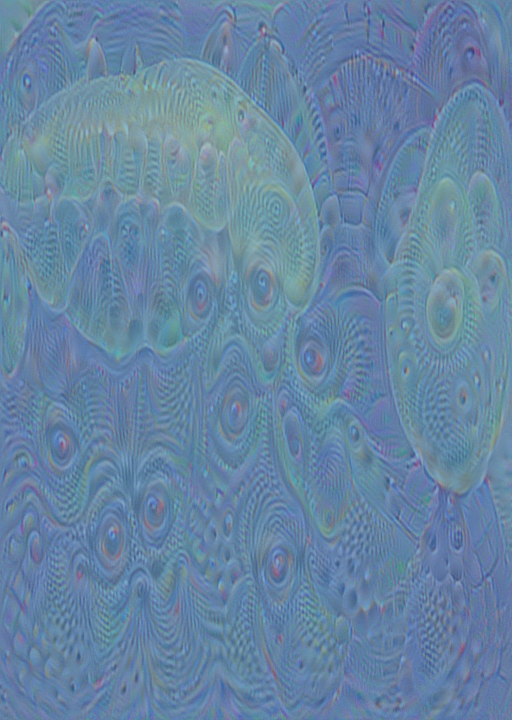
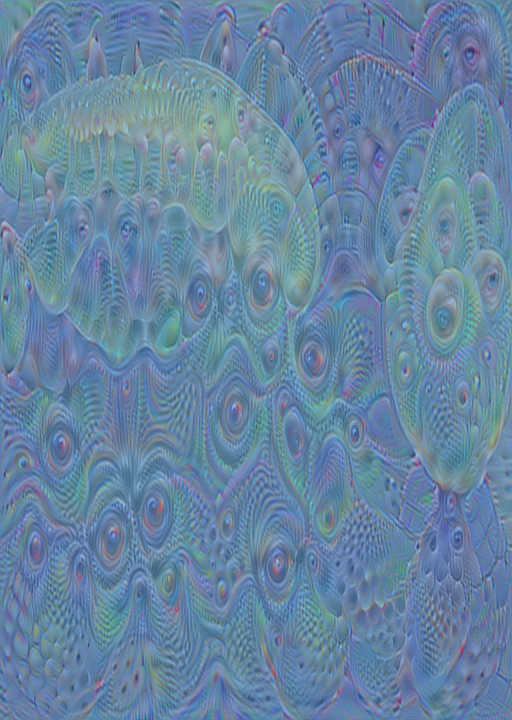
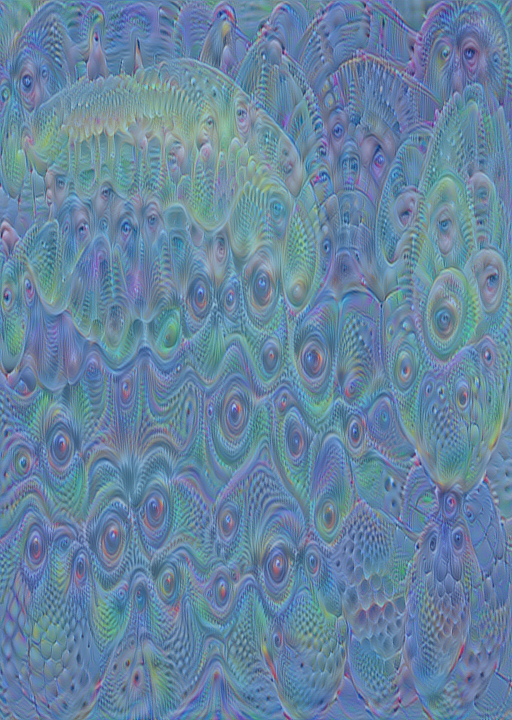
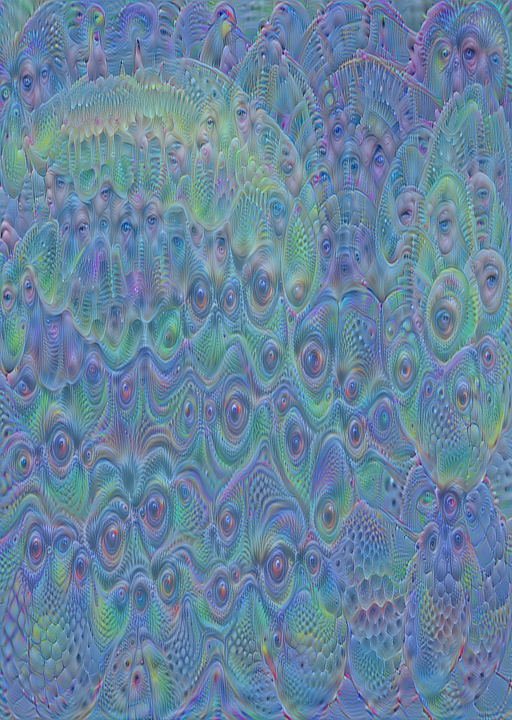
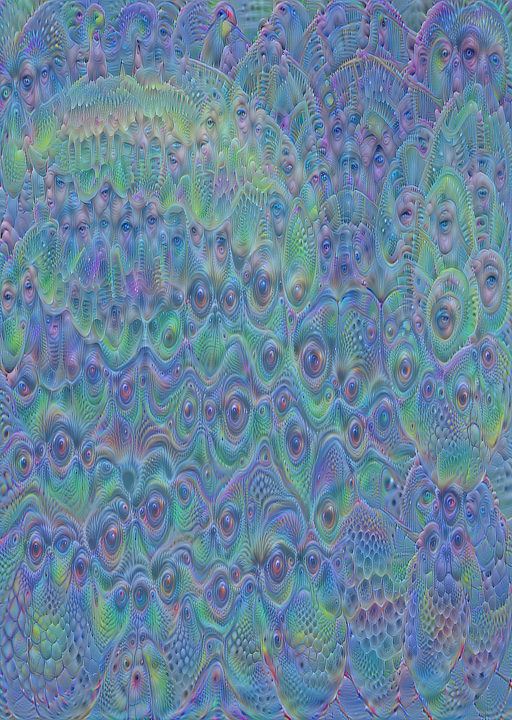

In [18]:
from visionlens.img_utils import display_images_in_table

octave_images_ = [(x - 0.15) / (1.0 - 0.1) for x in octave_images]

display_images_in_table(torch.cat((octave_images_), dim=0), n_rows=len(octave_images)//2)

In [19]:
from visionlens.img_utils import images_to_video, images_to_gif

In [21]:
all_images_ = [(x - 0.15) / (1.0 - 0.1) for x in all_images]

In [22]:
images_to_video(torch.cat((all_images_), dim=0), f"images/{image_name}.mp4")

In [ ]:
images_to_gif(torch.cat((all_images_), dim=0), f"images/{image_name}.gif")